# Tutorial for Site Discovery and Small-Molecule Screening Using the FASTDock Workflow

### To run this tutorial you will need a Conda environment with the following tools loaded/installed:
- pyCHARMM (https://academiccharmm.org/program)
- MMTSB (https://feig.bch.msu.edu/mmtsb/Main_Page)
- RDKit Python Package 
- OpenBabel

## Introduction to the FASTDock workflow 


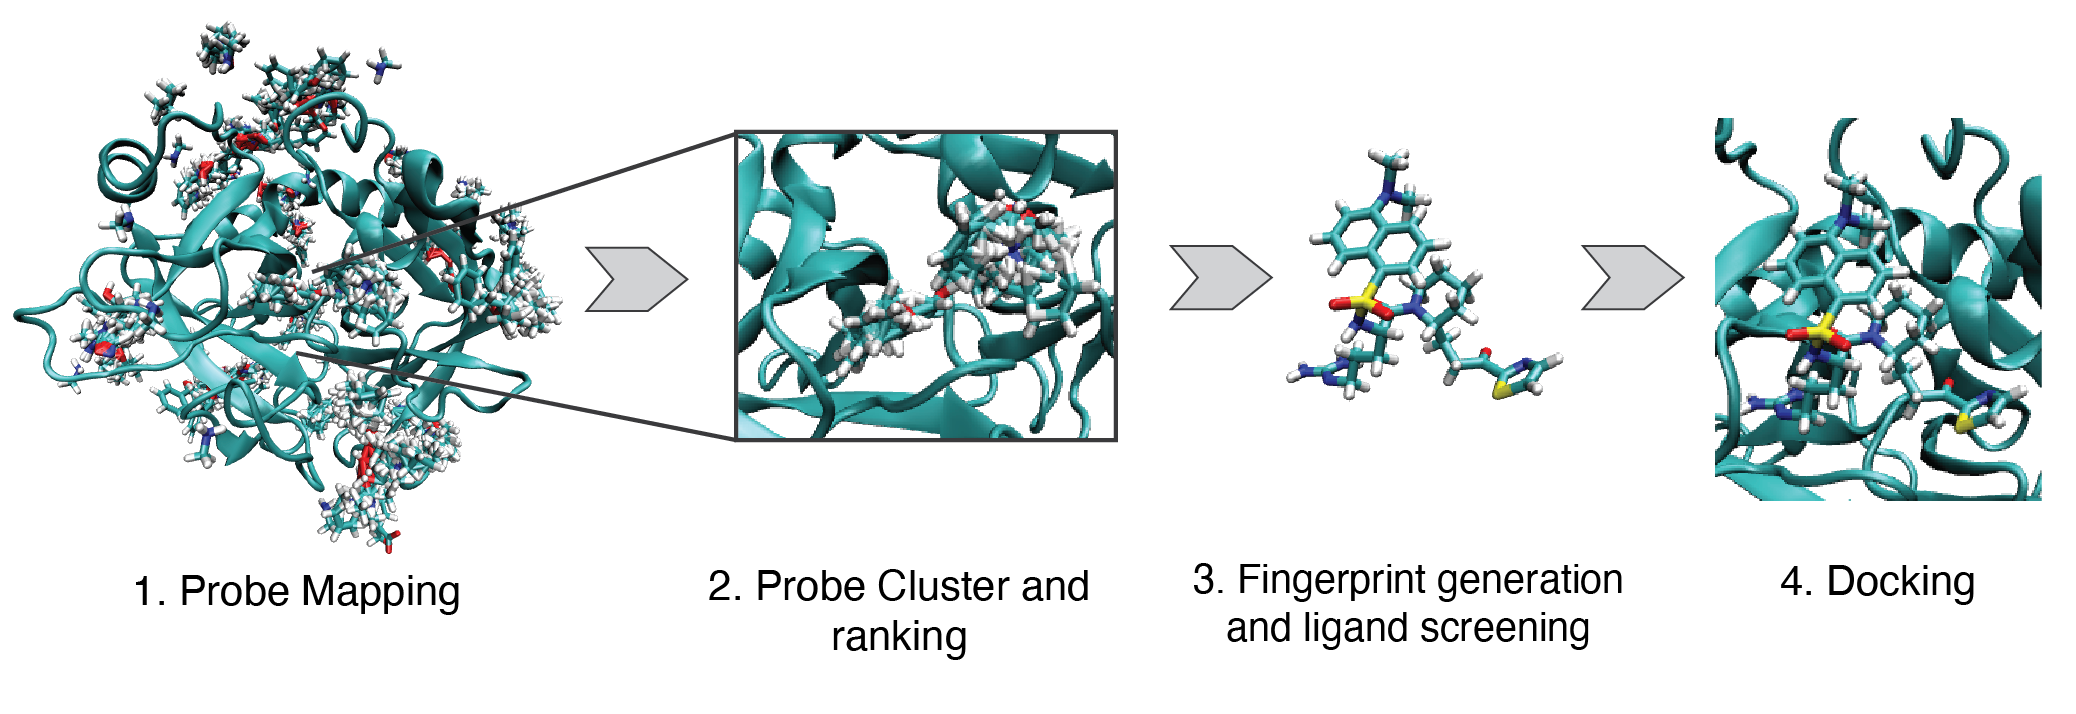

    1. Probe mapping methods to locate binding sites is a commonly used method, with many online servers available for this purpose. The FASTDock workflow begins by employing a CHARMM based FFT docking method to map 18 fragment probes to a given protein structure.
    
    2. Then, probes are clustered and clusters ranked based on the druggability of the identified site. 
    
    3. Once a site of interest is identified, the FASTDock cluster at that site is used to generate a chemical fingerprint. This fingerprint is then used as a reference to screen a database of chemical compounds. 
    
    4. Finally, a subset top ranked compounds from the ligand screening step are used for docking.
    
## This tutorial will cover steps 1-3. For a detailed example of small-molecule docking in CHARMM (CDOCKER), see https://github.com/BrooksResearchGroup-UM/pyCHARMM-Workshop.git

# General Set Up for the FASTDock Workflow

Step 1. import the required libraries. 
Step 2. Set up the grid generation and probe mapping parameters.

### dock_prob.py script region

In [ ]:
# pycharmm FASTDock test script 
import sys
import shutil
import os
import csv
import numpy as np

# find the current working directory to use below
cwd = os.getcwd()
## Set FASTDock parameters
exec(open(f'{cwd}/script/parameters.py').read())

sys.path.append(f'{cwd}/script')
if os.getenv('CHARMM_LIB_DIR') == None:
    os.environ['CHARMM_LIB_DIR'] = pyCHARMM_LIB
    print(os.getenv('CHARMM_LIB_DIR'))

from FASTDock import dock_probe

import pycharmm
import pycharmm.lib as lib
import pycharmm.psf as psf
import pycharmm.read as read
import pycharmm.lingo as lingo
import pycharmm.energy as energy
import pycharmm.minimize as minimize
import pycharmm.generate as gen
import pycharmm.settings as settings
import pycharmm.grid as grid
import pycharmm.coor as coor
import pycharmm.write as write

# Establish the directory for the test run
testdir = f'{cwd}/{testdir}'
if not os.path.exists(testdir): os.mkdir(testdir)
os.chdir(testdir)

### Print parameters from parameter file

In [ ]:
print('*'*90)
print(f'''
FFT Docking will be run in directory {testdir}. 
Docking will be done using a grid bin size of {dgrid} A and a buffer of {buff} A.
Using the psf and pdb from {protein_pdb} 
with segid {segid}. {nfrag} fragments with names 
{fragnames} will be docked. 
The top {nsave} poses will be saved for each fragment and the minimum number 
of cluster centers to be considered valid will be {minsize}. Minimization flag 
for fragments after docking is set to {addmin}.
''')
print('*'*90)


Step 3. Read in topology and parameter files.

In [ ]:
## Read in the topology and parameter file 
bl = settings.set_bomb_level(-1)
wl = settings.set_warn_level(-5)
v = settings.set_verbosity(-5)
read.rtf(f'"{cwd}/data/toppar/top_all36_prot.rtf"')
read.rtf(f'"{cwd}/data/toppar/top_all36_cgenff.rtf"', append = True)
read.rtf(f'"{cwd}/data/toppar/top_all36_cgenff.rtf"', append = True)
read.rtf(f'"{cwd}/data/toppar/probes.rtf"', append = True)
read.prm(f'"{cwd}/data/toppar/par_all36m_prot.prm"', flex = True)
read.prm(f'"{cwd}/data/toppar/par_all36_cgenff.prm"', append = True, flex = True)
read.prm(f'"{cwd}/data/toppar/probes.prm"', append = True, flex = True)
settings.set_bomb_level(bl)
settings.set_warn_level(wl)
settings.set_verbosity(v)

# Setting up grid generation for probe mapping 

Begin by reading in the protein. For our test case, we will be using a structure of Abl kinase (PDB: 2HYY). This file must be in a CHARMM-readable format. We need to center the protein for later purposes, so we will write out a file "final_protein.pdb" to use for visualization with our grid-mapped probes.

In [ ]:
## Build protein
read.psf_card(protein_psf, append = True)
read.pdb(protein_pdb, resid = True)
coor.orient(by_rms=True,by_mass=False,by_noro=False)
write.coor_pdb('final_protein.pdb')

To generate the grid, we need to first set the box size based on our protien. 

In [ ]:
# set box size and center
stats = coor.stat()
xs = stats['xmax'] - stats['xmin']
ys = stats['ymax'] - stats['ymin']
zs = stats['zmax'] - stats['zmin']

smax = np.amax([xs,ys,zs]) + buff

Now we are ready to generate the grid and save this to a file.

In [ ]:
# set grid parameters, nonbonded options and generate grid
nbond_opt = {'cutnb' : 14 , 'ctofnb' : 12 , 
                                        'ctonnb' : 10, 'eps' : 2,
                                        'rdie' : True, 'e14fac' : 1}
pycharmm.NonBondedScript(**nbond_opt).run()
genGrid = grid.CDOCKER()
settings = {'xCen' : stats['xave'], 'yCen' : stats['yave'], 'zCen' : stats['zave'],
            'xMax' : smax, 'yMax' : smax, 'zMax' : smax,
            'dGrid' : dgrid,
            'emax' : 2, 'maxe' : 40, 'mine' : -20, 'dielec' : 2, 'flag_gpu' : True,
            'rdie' : True,
            'nbond_opt' : nbond_opt,
            'gridFile' : 'grid/protein_grid.bin',
            'probeFile' : f'"{cwd}/data/toppar/fftdock_c36prot_cgenff_probes.txt"'}

genGrid.setVar(settings)

if os.path.exists('grid'): shutil.rmtree('grid')
os.mkdir('grid')

genGrid.generate()

psf.delete_atoms(pycharmm.SelectAtoms().all_atoms())

# Probe mapping onto the generated grid

We dock the probes to the grid using the dock_probe function. This function takes a list of probe names (fragnames), the number of poses to save per probe (nsave), and the unit the grid file has been read into (unit). 

In [ ]:
if os.path.exists('scores'): shutil.rmtree("scores")
if os.path.exists('pdb_dock'): shutil.rmtree('pdb_dock')
os.mkdir('scores')
os.mkdir('pdb_dock')

dock_probe(cwd, addmin, randlig, fragnames, nsave, unit=30)

# Cluster and score mapped probes

Now that we have mapped all 18 probes to our protein, we are ready to cluster and rank all the probes. The regions with a variety of probes mapped classify as binding hotspots, and will be likely binding sites. We being by first clustering all the chemotypes together using MMTSB to cluster probes of the same chemotype within a 2A distance together. We then pull out the representative pose for each cluster (the pose with the lowest RMSD from the center) to use for all future calculations. In this stage, we also filter out clusters with memebership less than 10, as they are not statistically relevant.

Initial clustering is done using the function cluster_n_score, which takes as input only the list of probe names. To speed up calculations, we will do this in parallel for all probes. To obtain the representatives, we use the function find_rep, which takes as input a probe name (name), the number of poses saved for the probe (nsave), and the number at which to start indexing the probe residue in the output pdb files. We start this number high to avoid overlap in numbering with the protein. This is important for future steps.

In [ ]:
import itertools
import multiprocessing
import subprocess
from FASTDock import dock_probe, cluster_n_score, find_rep, get_cluster, score

if shutil.which('convpdb.pl') == None:
    print('Cannot find MMTSB Tool convpdb.pl, need MMTSB Tools installed')
    exit()
# Cluster and score chemotypes
if os.path.exists('clusters'):
        shutil.rmtree('clusters')
        if os.path.exists('cluster-n-score.log'): os.remove('cluster-n-score.log')
        if os.path.exists('top.txt'): os.remove('top.txt')

os.makedirs('clusters/reps')

pool = multiprocessing.Pool()
pool.map(cluster_n_score, list(zip(itertools.repeat(cwd),fragnames)))
pool.close()

# get cluster representatives
for name in fragnames:
    j = fragnames.index(name)
    j = j*100
    find_rep(name, nsave, j)

Here, we generate one file containing representatives for all chemotypes and their clusters that contain more than 10 members. The names of clusters with greater than 10 members are written out in the previous step into the file "top.txt." We now read this file and write all poses into "before_clustering.pdb."

In [ ]:
# generate one file with final poses
file = open('top.txt', 'r')
files = []
for line in file.readlines():
    files.append(line.rstrip())
file.close()
for name in sorted(files):
    with open('before_clustering.pdb', 'ab') as outFile:
        with open(f'clusters/reps/{name}', 'rb') as com:
            outFile.write(com.read())

os.system('sed -i /REMARK/d before_clustering.pdb')
os.system('sed -i /END/d before_clustering.pdb')
os.system('convpdb.pl -segnames -renumber 1 before_clustering.pdb > tmp')
os.system('sed -i s/PRO0/LIG/g tmp')
os.system('mv tmp before_clustering.pdb')
os.system('rm top.txt')

We are now ready to generate the final FASTDock Clusters. To do this, we will first list the highest scoring pose for each probe type. This will be used as the probe center for the FASTDock clusters. Using this list, we will generate the FASTDock clusters with the get_cluster function. This function takes as input the probe name for the pose to be used as the center of the FASTDock cluster. 

In [ ]:
## List highest scoring pose for each probe type
top = []
for name in fragnames:
    # Sort all entries for {name} based on field 12 (cluster size)
    command = f"grep {name} cluster-n-score.log | sort -grk 12 "
    # Advance cluster only if cluster membership is >= {minsize}
    command += f"| awk ' $NF >= {minsize} ' | head -n 1 | awk '{{print $6}}'"
    pose = subprocess.check_output(command, shell=True)
    pose = pose.strip().decode('utf-8')
    top.append(f'{name}-{pose}')

if os.path.exists('final'):
        shutil.rmtree('final')
        if os.path.exists('score.txt'): os.remove('score.txt')

os.mkdir('final')

for probe in top:
    get_cluster(probe, top)


Finally, we will remove any duplicate FASTDock clusters and score the remaining clusters using the function score. Scoring is done based on the ratio of protein-cluster contacts to the number of probes in the cluster. 

In [ ]:
# get uniqe clusters and score
os.chdir('final')

os.mkdir('tmp')
for probe in top:
    # print cluster coordinates to tmp file
    os.system(f"grep ATOM {probe}_final.pdb | awk '{{print $6, $7, $8}}' > tmp/{probe}") 

os.chdir('tmp')
# check if coordinates for any clusters match
os.system("md5sum * | sort -u -k1,1 | awk '{print $2}' > scorelist") 
unique_clusters = np.loadtxt('scorelist',dtype=str)

os.chdir('../')
shutil.rmtree('tmp')
os.chdir('../')

for probe in unique_clusters: 
    score(probe,minsize,protein_psf,protein_pdb)

# Screening a small-molecule library using a FASTDock cluster

Now that we have located binding sites and have FASTDock clusters for each site, we will select the cluster in the active site for further screening. The scores for each site are in the file score.txt. Let's take a look and see which site has the highest score.

In [ ]:
print(np.loadtxt(f'{testdir}/score.txt',dtype=str))

Step 1. Import the required libraries.

In [ ]:
from rdkit import Chem
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
from rdkit.Chem.Pharm2D import Generate
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D
from rdkit.Chem import MACCSkeys

Step 2. Set up parameters for screening. The database we will be using here is a collection of molecules from co-crystal strcutures known to bind to various sites on Abl kinase. Each ligand is named for the PDB ID of the crystal structure it was retrieved from. 

Here we will find the site from the current run with the largest score and use this as our target reference. We will aslso check to see whether Open Babel (obabel) is present.

In [ ]:
# Read the scores from cluster_and_score.py output then pick cluster with largest score
s = open(f'{testdir}/score.txt','r')
scores = {}
for l in s:
    scores[l.split()[1]] = float(l.split()[0])
scores = dict(sorted(scores.items(), key=lambda item: item[1],reverse=True))
ref_cluster = list(scores.keys())[0]
refpdb = f'{testdir}/final/{ref_cluster}_final.pdb' # path to ligand file for reference molecule
database = f'{cwd}/data/database.sdf' # path to sdf file containing database for screening
filename = f'{testdir}/final/{ref_cluster}_tanimoto' # name for score output
ref = f'{testdir}/final/{ref_cluster}_final.mol2'
if shutil.which('obabel') == None:
    print('Cannot find openbabel obabel, need obabel installed')
    exit()
# Use openbabel to make refpdb into ref (mol2)
os.system(f'obabel -ipdb {refpdb} -O {ref}')

Step 3. Generate a MACCS fingerprint for the reference molecule and your database. 

In [ ]:
# load in reference molecule 
mol = Chem.MolFromMol2File(f'{ref}')
ref_feat = MACCSkeys.GenMACCSKeys(mol)

# load in ligand library
suppl = Chem.SDMolSupplier(f'{database}')

ms = [lig for lig in suppl if lig is not None] # filter out molecules with atom-types not supported by RDKit
lig_name, score = [], []

Step 4. Caclulate the TANIMOTO similarity for each compound in the database to the reference. Write out this information to a file for later use.

In [ ]:
for lig in ms:
    Chem.AddHs(lig)
    name = lig.GetProp("_Name")
    print("Now processing ", name)
    lig_name.append(name)

    # generate pharmacophore features 
    feat = MACCSkeys.GenMACCSKeys(lig)

    # calculate TANIMOTO similarity
    s = DataStructs.FingerprintSimilarity(ref_feat,feat) # TANIMOTO
    score.append('{:.4f}'.format(s))

ref_name = [mol.GetProp("_Name").split('/')[-1]] * len(score)

rows = zip(ref_name,lig_name,score)
with open(f'{filename}.csv', "w") as f:
    writer = csv.writer(f, delimiter='\t')
    for row in rows:
        writer.writerow(row)

We can now look at the scores of every compound. The output file lists the name of the compound used for screening in column 1, ligand name in column 2, and TANIMOTO score in column 3.

In [ ]:
os.chdir(cwd)
print(np.loadtxt(f'{filename}.csv',dtype=str))

## Visualize final cluster using  py3DMol

In [ ]:
import py3Dmol
# Move back to our current root 
os.chdir(cwd)
import random
colors = {i: "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(120)}
s = open(f'{testdir}/score.txt','r')
scores = {}
for l in s:
    scores[l.split()[1]] = float(l.split()[0])
scores = dict(sorted(scores.items(), key=lambda item: item[1],reverse=True))
print(scores.keys())
ct = []
pdbs = []
view = py3Dmol.view()#width=500, height=500)
view.setBackgroundColor('black')
for i, probe in enumerate(list(scores.keys())):
    ct.append(colors[i])
    pdbs.append(probe)
    view.addModel(open(f'{testdir}/final/{probe}_final.pdb','r').read(),'pdb')
    if i == 0: 
        view.setStyle({'model':i},{'stick':{'color': colors[i]}})
        view.addSurface(py3Dmol.VDW,{'opacity': 1.0,'color': colors[i]},{'model':i})
        view.addLabel(f'{i}',
                      {'position':{'model':i},'fontOpacity':1,'showBackground':True,
                      'backgroundColor':colors[i],'fontColor':'white','inFront':True,
                      'fixed':False},
                      {'model':i})
    else: 
        view.setStyle({'model':i},{'stick':{'opacity': 1.0,'color': colors[i]}})
        view.addSurface(py3Dmol.VDW,{'opacity': 0.75,'color': colors[i]},{'model':i})
        view.addLabel(f'{i}',
                      {'position':{'model':i},'fontOpacity':1,'showBackground':True,
                      'backgroundColor':colors[i],'fontColor':'white','inFront':True,
                      'fixed':False},
                      {'model':i})

view.addModel(open(f'{testdir}/final_protein.pdb','r').read(),'pdb')
view.setStyle({'model':len(scores)},{'cartoon':{'color': 'lightblue'}})
view.addSurface(py3Dmol.SES,{'opacity': 0.8,'color': 'white'},{'model':len(scores)})
view.zoomTo()
view